참고 링크 : https://wikidocs.net/24586

# IMDB 리뷰 감성 분류하기(IMDB Movie Review Sentiment Analysis)
----
IMDB 는 영화 사이트이며 , 감성 분류 연습을 위해 자주 사용되는 대표적인 데이터이다. 긍정인경우는 1, 부정인 경우는 0으로 표시한 레이블로 구성된 데이터이다.

케라스에서는 해당 IMDB 영화 리뷰 데이터를 imdb.load_data() 함수를 통해 바로 다운로드 할 수 있도록 지원하고 있습니다. 케라스로부터 해당 데이터를 다운로드 받아 감성 분류를 수행하는 모델을 만들어보겠습니다.

In [9]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.datasets import imdb

import re
import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

##### X : text Data    // Y : Sentiment Data

In [10]:
(X_train, y_train) , (X_test, y_test) = imdb.load_data()
#(X_train, y_train) , (X_test, y_test) = imdb.load_data(num_words = 10000)  

In [11]:
print('훈련용 리뷰 개수 : {}'.format(len(X_train)))
print('테스트용 리뷰 개수 : {}'.format(len(X_test)))
num_classes = max(y_train) + 1
print('카테고리 : {}'.format(num_classes))

훈련용 리뷰 개수 : 25000
테스트용 리뷰 개수 : 25000
카테고리 : 2


In [12]:
# X train 구조 확인 => 모두 Emebedding 되어있음을 확인 할 수 있다.
print(X_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


##### 25,000 개의 훈련용 리뷰 데이터의 리뷰 길이 그래프로 시각화

리뷰의 최대 길이 : 2494
리뷰의 평균 길이 : 238.71364


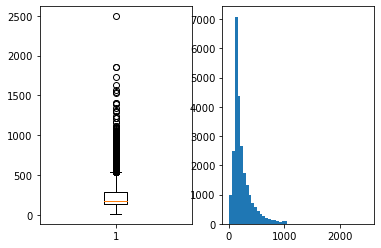

In [13]:
len_result = [len(s) for s in X_train]

print('리뷰의 최대 길이 : {}'.format(np.max(len_result)))
print('리뷰의 평균 길이 : {}'.format(np.mean(len_result)))

plt.subplot(1,2,1)
plt.boxplot(len_result)
plt.subplot(1,2,2)
plt.hist(len_result, bins=50)
plt.show()

In [14]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 레이블에 대한 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 레이블에 대한 빈도수:
[[    0     1]
 [12500 12500]]


##### IMDB 리뷰 데이터는 0,1,2,3 인덱스를 중요시 여긴다고 함 // 데이터셋의 특징이므로 , 큰 신경 안써도 될듯

In [15]:
word_to_index = imdb.get_word_index()
index_to_word={}
for key, value in word_to_index.items():
    index_to_word[value+3] = key

In [16]:
print('빈도수 상위 1등 단어 : {}'.format(index_to_word[4]))

빈도수 상위 1등 단어 : the


In [17]:
print('빈도수 상위 3938등 단어 : {}'.format(index_to_word[3941]))

빈도수 상위 3938등 단어 : suited


##### X_train[0] 의 데이터는 아래와 같음을 볼 수 있다.

In [18]:
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token

print(' '.join([index_to_word[index] for index in X_train[0]]))

<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and shoul

# 2. LSTM으로 IMDB 리뷰 감성 분류하기
----


In [19]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

##### 단어 집합의 크기를 10,000 으로 제한

In [20]:
vocab_size = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = vocab_size)

##### pad_sequences() : 훈련 데이터가 정한 길이를 초과하면 초과분을 삭제하고, 부족하면 0으로 채움

In [21]:
max_len = 500
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

##### Embedding() 
- 첫번째 인자 : 단어 집합의 크기
- 두번째 인자 : 임베딩 후의 벡터 크기<br>
##### 즉 , 아래에서는 모든 입력데이터에서 모든 단어는 100차원의 임베딩 벡터로 표현됨 

In [22]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))

__검증 데이터 손실이 4회 증가하면 학습을 중단하는 조기 종료(EarlyStopping)를 사용합니다. <br>
또한, ModelCheckpoint를 사용하여 검증 데이터의 정확도가 이전보다 좋아질 경우에만 모델을 저장하도록 합니다.__

In [23]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1 , patience = 4)
mc = ModelCheckpoint('GRU_model.h5', monitor='val_acc', mode = 'max', verbose = 1 , save_best_only = True)

##### 이진 분류 이므로 , 출령층을 뉴런 하나와 , 활성화 함수로 시그모이드 함수를 사용한다.

In [24]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs = 15, callbacks = [es, mc], batch_size = 54, validation_split = 0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/15
19980/20000 [============================>.] - ETA: 0s - loss: 0.5080 - acc: 0.7532
Epoch 00001: val_acc improved from -inf to 0.84500, saving model to GRU_model.h5
20000/20000 [==============================] - 27s 1ms/sample - loss: 0.5084 - acc: 0.7531 - val_loss: 0.3612 - val_acc: 0.8450
Epoch 2/15
19980/20000 [============================>.] - ETA: 0s - loss: 0.3140 - acc: 0.8770
Epoch 00002: val_acc improved from 0.84500 to 0.86980, saving model to GRU_model.h5
20000/20000 [==============================] - 24s 1ms/sample - loss: 0.3139 - acc: 0.8770 - val_loss: 0.3121 - val_acc: 0.8698
Epoch 3/15
19980/20000 [============================>.] - ETA: 0s - loss: 0.2361 - acc: 0.9089
Epoch 00003: val_acc did not improve from 0.86980
20000/20000 [==============================] - 23s 1ms/sample - loss: 0.2362 - acc: 0.9087 - val_loss: 0.3704 - val_acc: 0.8382
Epoch 4/15
19980/20000 [============================>.] - ETA: 0s -

##### load model에서 OS Error 뜨는데 , 오류에 대한 설명도 없고 ,, 구글링 아무리해도 해결못함

In [26]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

OSError: 

##### 훈련과정중 가장 정확도 높앗을 때 저장된 모델이 아닌 , 마지막 시점의 모델을 사용한것이라 , 정확도는 좀 더 낮을 수 있다.

In [ ]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

# 3. 모델 검증
----


In [ ]:
def sentiment_predict(new_sentence):
    # 알파벳과 숫자를 제외하고 모두 제거 및 알파벳 소문자화
    new_sentence = re.sub('[^0-9a-zA-Z ]', '' , new_sentence).lower()
    
    # 정수 인코딩
    encoded = []
    for word in new_sentence.split():
        # 단어 집합의 크기를 10,000으로 제한
        try:
            if word_to_index[word] <= 10000:
                encoded.append(word_to_index[word] + 3)
            else:
            # 10,000 이상의 숫자는 <unk> 토큰으로 취급
                encoded.append(2)
        
        
        # 단어 집합에 없는 단어는 <unk> 토큰으로 취급.
        except KeyError:
            encoded.append(2)
            
    pad_new = pad_sequences([encoded], maxlen = max_len) # 패딩
    score = float(model.predict(pad_new)) # 예측
    
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.".format(( 1 - score) * 100))

##### IMDB 사이트에서 영화 블랙팬서의 1점 리뷰를 활용하여 , 부정으로 제대로 예측하는지 테스트

In [ ]:
temp_str = "This movie was just way too overrated. The fighting was not professional and in slow motion. I was expecting more from a 200 million budget movie. The little sister of T.Challa was just trying too hard to be funny. The story was really dumb as well. Don't watch this movie if you are going because others say its great unless you are a Black Panther fan or Marvels fan."

sentiment_predict(temp_str)

In [ ]:
temp_str = " I was lucky enough to be included in the group to see the advanced screening in Melbourne on the 15th of April, 2012. And, firstly, I need to say a big thank-you to Disney and Marvel Studios. \
Now, the film... how can I even begin to explain how I feel about this film? It is, as the title of this review says a 'comic book triumph'. I went into the film with very, very high expectations and I was not disappointed. \
Seeing Joss Whedon's direction and envisioning of the film come to life on the big screen is perfect. The script is amazingly detailed and laced with sharp wit a humor. The special effects are literally mind-blowing and the action scenes are both hard-hitting and beautifully choreographed."

sentiment_predict(temp_str)

>- 긍정과 부정에 대한 정확도가 상당히 높음을 볼 수 있었습니다.